Для прогнозирования используются данные о покупках юзеров за период 2021 года. Всего доступно больше 2 млн. строк.

Флаг оттока проставляется, если после покупки юзера прошло больше 45 дней.

Поведение юзера описывается историей его покупок, суммой чека и размером скидки к чеку. В компании действует программа лояльности, участвуя в которой юзеры получают скидку на любую покупку и могут получать дополнительные скидки по разным промо-акциями.

Описание данных:
data.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'timestamp'` - дата и время совершения покупки, datetime
* `'gest_Sum'` - сумма покупки, float
* `'gest_Discount'` - сумма скидки, float

target.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'target'` - флаг оттока, int: 1 если юзер ушел в отток | 0 если НЕ отток

## Что здесь можно сделать? - Заметки 
**Нужно помнить, что по сути это тайм серия.**  
Т.е. я предполагаю, что клиент покупает, покупает, покупает, потом фигак и перестал покупать. Один клиент - один вектор.
А тут куча вектором принадлежат одному клиенту. 

Т.е. я бы даже сказал, что в том виде в котором оно есть, модель особо-то ничего не найдет. Как она сможет по дате, сумме покупки и скидке предсказать уйдет человек или нет, не зная его истории?

**Что может говорить, что клиент собрался уйти и не вернуться?**  
Т.е. гипотетически что может говорить о том, что клиент собирается уйти и не вернуться?
1. Увеличивается интервал между покупками от покупки к покупке. Типа 1 день, потом 2, потом 5 и т.д.
2. Как-то изменяется объем чека (уменьшается, увеличивается?) 
3. Как-то меняется ассортимент (типа вот он покупал одно и тоже, а тут вдруг перестал покупать одно и тоже (испортился товар на его вкус) и он либо сразу ушел, либо попробовал другое и остался, либо попробовал другое - ему не понравилось - ушел

**Как должен работать предикт? Какие данные должны поступать на вход?**  
Это видимо тоже относится к тому, что это своего рода таймсерия

**Если сейчас дать модели на вход просто дату, сумму чека и скидку...**  
То она будет пытаться предсказать отток исключительно по дате, сумме чеку и скидке - врядли у нее что-то получится взразумительное.


**Сумма в месяц стабильна для юзера, а отклонение может указывать на отток**  
По результатам уже проведенного анализа есть такой вывод:
сумма, которую готов тратить юзер в месяц,  достаточна стабильна и слабо меняется со временем. Потратив в этом месяце больше обычного, юзер скорее всего в следующем не будет покупать;

По каждому клиенту взять средний чек, каким-то образом определить порог отклонения от этого среднего чека и посмотреть насколько факт этого отклонения коррелирует с оттоком. Может это будет хорошая фича. Но проблема в том, что для предсказания не достаточно 

**Самый простой и очевидный способ подготовки данных**  
Это взять по каждому клиенту кол-во покупок, min,max,mean,median,stdev по gest_Sum, gest_Discount, и перерывом между покупками

**Вариант еще лучше!**  
Используем каждую строку как есть, не переводим ее в строку по уникальному клиенту, а точно также одна строка одна сделка.
К каждой такой строке мы накопительно добавляем кумулятивную инфу о клиенте, т.е.:
* Сколько дней на момент сделки прошло с момента первой сделки
* Какой на текущий момент средний чек
* Какая разница между среднем чеком и чеком сделки
* Сколько сделок произошло на момент текущей сделки
* Сколько сделок в месяц в среднем

## Описание общего подхода

Я вот вижу 3 общих подхода:
1. Рассматривать покупки клиентов как таймсерию, и исходя из прошлого поведения прогнозировать будущее. 
    * Мы таймсерии не проходили, плюс задача оттока традиционно не решается предсказанием таймсерии, поэтому от этого варианта скорее откажемся. Даже несмотря на то, что можно как-то обучить модель на скользящем окне (я точно не знаю как).
2. Преобразовать данные так, чтобы получилось по одной строке на каждого клиента, в которой будет какая-то агрегированная информация о покупках. В надежде, что модель найдет какие-то закономерности именно в общей репрезентации истории. 
3. Использовать данные в том виде, в котором они уже есть. Т.е. каждая строка это одна сделка. Но добавить к ним накопительную информацию об истории клиента. (Спасибо нашему ментору, который подсказал этот подход)
    * Т.е. к каждой сделке добавить инфу о кол-ве уже совершенных покупок, кол-во прошедших дней с предыдущей покупки, и другое.
    * Такой подход позволит модели сравнивать историю с текущей сделкой, что повышает ценность информации по сравнению с предыдущим подходом.
    
    
Наверное, главный мой вопрос для всех: какие есть еще подходы к решению задачи?

И перейдя на уровень ниже, предполагаю, что эффективность любого подхода зависит от того, какие фичи мы создадим/добавим.
А какие фичи нужно добавить зависит от того, как мы себе представляем механику и причины оттока клиентов.

Здесь можно как-то самостоятельно (коллективно) очертить эту механику, составить список фичей и уже отдать на откуп модели, чтобы она там сама определила какие фичи важны - какие нет.
Либо воспользоваться уже какой-то готовой теорией, например тот же RFM-анализ, о котором говорил Родион.
Не ясно какой подход эффективнее, т.е. стоит ли погружаться в теорию и если стоит то ради чего (только ради списка фичей, например)?
Это вот второй вопрос, который хотел бы обсудить.


И третий вопрос: про то, в каком виде будут приходить данные на предикт.
Это может повлиять на то, как нужно будет обучать модель.
Например, если предикт будет происходить исключительно по данным за последний месяц и только, то какой-то условный скрипт предобработки, который будет, например, считать средний чек может сильно ошибиться, т.к. ему будет не хватать данных. А модель мы обучали на целом годе и там статистики будут поточнее. И так возникает расхождение.
Вот такого рода ограничения. Я, к сожалению, другие примеры придумать не могу, но это все может сильно повлиять на архитектуру обработки данных и как следствие на то, что стоит ожидать от модели.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# pd.set_option('display.max_rows', 100)

In [3]:
df = pd.read_csv('data/data.csv')
df_target = pd.read_csv('data/target.csv')

In [4]:
display(df.head())
df_target.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000000,300.0
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000000,55.0
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500000,25.5
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000000,0.0
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.899994,3.1


,clnt_ID,target
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,1
1,00007EB0-6331-438E-A917-E9840C260876,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,0


## Предобработка датасетов

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371635 entries, 0 to 2371634
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   clnt_ID        object 
 1   timestamp      object 
 2   gest_Sum       float64
 3   gest_Discount  float64
dtypes: float64(2), object(2)
memory usage: 72.4+ MB


In [6]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255109 entries, 0 to 255108
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   clnt_ID  255109 non-null  object
 1   target   255109 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


* timestamp - object, а не datetime

Изменим тип данных в timestamp на datetime

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

Добавим столбец с только датой.

In [8]:
df['date'] = df['timestamp'].dt.date

Проверим на дубликаты и пропуски.

In [9]:
df.isna().sum()

clnt_ID          0
timestamp        0
gest_Sum         0
gest_Discount    0
date             0
dtype: int64

Пропусков нет.

In [10]:
df.duplicated().sum()

129

Есть дубликаты, посмотрим на них.

In [11]:
df.loc[df.duplicated(keep=False)]

,clnt_ID,timestamp,gest_Sum,gest_Discount,date
639,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00,982.200012,0.000000,2021-01-02
663,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00,982.200012,0.000000,2021-01-02
85786,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00,1189.000000,0.000000,2021-01-14
85787,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00,1189.000000,0.000000,2021-01-14
133279,A145C6F8-EDCB-47B1-BF5D-B328F6AF97CA,2021-01-20 16:00:00,0.000000,0.000000,2021-01-20
...,...,...,...,...,...
2165277,E99EFF35-01BE-49A9-8F61-641F752051E5,2021-11-08 15:00:00,0.000000,0.000000,2021-11-08
2174627,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00,282.239990,37.759998,2021-11-10
2174629,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00,282.239990,37.759998,2021-11-10
2198034,C9D86AF9-373C-4531-92A4-8FC752DD5D75,2021-11-14 12:00:00,0.000000,0.000000,2021-11-14


Удалим дубликаты.

In [12]:
df = df.drop_duplicates()

In [13]:
df.duplicated().sum()

0

Дубликаты удалили.

## Нужно создать фичи

Для анализа нужно создать фичи

Общая стоимость заказа без скидки = `gest_Sum + gest_Discount`

In [14]:
df['gest_total'] = df['gest_Sum'] + df['gest_Discount']

**Как создавать сложные фичи?**

* У нас есть целиковый датасет
* Нужно группировать его по клиентам
* Нужно к этим группам применять разные методы, чтобы уже эти фичи создать

`df.groupby('cnlt_ID').transform(func)`

**Какие создавать фичи?**
* Сколько дней на момент текущей сделки прошло с момента первой сделки
* Какой на текущий момент средний чек
* Какая разница между среднем чеком и чеком сделки
* Сколько сделок произошло на момент текущей сделки
* Сколько сделок в месяц в среднем

Сколько дней прошло с момента первой сделки

1. Берем min(date)
2. Вычитаем из текущей data min(date) (`df['date'] - df['first_buy_date']`)

In [15]:
def first_buy_date(col):
#     print(col.min())
    return col - col.min()
df['first_buy_date_delta'] = df.groupby('clnt_ID')['date'].transform(first_buy_date)
df['first_buy_timestamp_delta'] = df.groupby('clnt_ID')['timestamp'].transform(first_buy_date)

<AxesSubplot:>

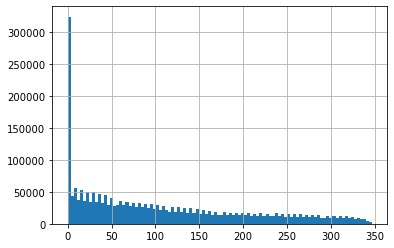

In [16]:
df['first_buy_date_delta'].dt.days.astype('int').hist(bins=100)

<AxesSubplot:>

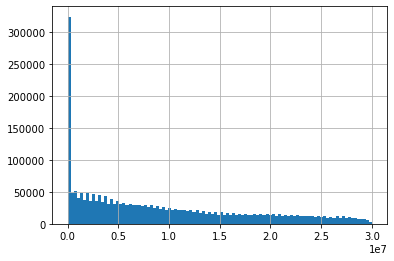

In [17]:
df['first_buy_timestamp_delta'].dt.total_seconds().astype('int').hist(bins=100)

**Какой на текущий момент средний чек**

Берем кумулятивную сумму чека и делим на 

А лучше используем `series.expanding().mean()`
`df.groupby('clnt_ID').transform()`

При этом нам нужен среднее кол-во денег, которое отдал клиент, и средняя стоимость без учета скидки.

In [18]:
def expand_mean(col):
    return col.expanding().mean()
df['clnt_gest_Sum_avg'] = df.groupby('clnt_ID')['gest_Sum'].transform(expand_mean)
df['clnt_gest_total_avg'] = df.groupby('clnt_ID')['gest_total'].transform(expand_mean)

In [21]:
df.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,date,gest_total,first_buy_date_delta,first_buy_timestamp_delta,clnt_gest_Sum_avg,clnt_gest_total_avg
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000000,300.0,2021-01-02,1200.000000,0 days,0 days,900.000000,1200.000000
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000000,55.0,2021-01-02,220.000000,0 days,0 days,165.000000,220.000000
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500000,25.5,2021-01-02,826.000000,0 days,0 days,800.500000,826.000000
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000000,0.0,2021-01-02,580.000000,0 days,0 days,580.000000,580.000000
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.899994,3.1,2021-01-02,151.999994,0 days,0 days,148.899994,151.999994


<AxesSubplot:>

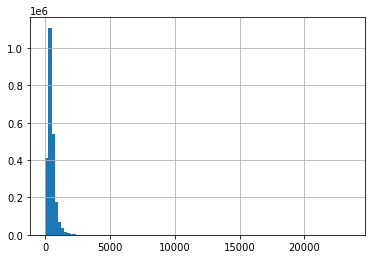

In [26]:
df['clnt_gest_Sum_avg'].hist(bins=100)

**Какая разница между среднем чеком и чеком сделки**
Считаем для кол-ва денег и для стоимости без учета скидки (пока не ясно надо ли)

Берем текущий чек и из него вычитаем средний.
Тоже самое без учета скидки.

`df['gest_Sum'] - df['clnt_gest_Sum_avg']`
`df['gest_total'] - df['clnt_gest_total_avg']`

In [27]:
df['gest_Sum_delta_from_avg'] = df['gest_Sum'] - df['clnt_gest_Sum_avg']
df['gest_total_delta_from_avg'] = df['gest_total'] - df['clnt_gest_total_avg']

<AxesSubplot:>

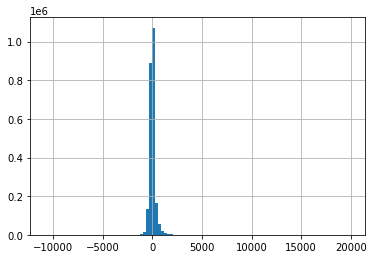

In [30]:
df['gest_total_delta_from_avg'].hist(bins=100)

**Сколько сделок произошло на момент текущей сделки**
series.expanding().count()

In [33]:
def expand_count(col):
    return col.expanding().count()

df['clnt_buys_count'] = df.groupby('clnt_ID')['timestamp'].transform(expand_count)

In [38]:
df['clnt_buys_count'].describe()

count    2.371506e+06
mean     3.398758e+01
std      5.565126e+01
min      1.000000e+00
25%      4.000000e+00
50%      1.600000e+01
75%      4.200000e+01
max      1.314000e+03
Name: clnt_buys_count, dtype: float64

<AxesSubplot:>

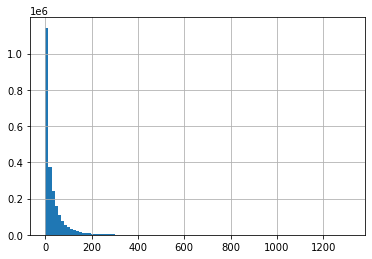

In [37]:
df['clnt_buys_count'].hist(bins=100)

## EDA

Объединим датасеты для анализа.

In [ ]:

df_eda = df.merge(df_target,on='clnt_ID')
display(df_eda.head(),df_eda.info(),df_eda.isna().sum())

Посмотрим кол-во уникальный айдишников.

In [ ]:
display(df['clnt_ID'].nunique())
df_target['clnt_ID'].nunique()

255109 клиентов. При этом в датасете с таргетом тоже 255109 записей. Значит все верно.

Посмотрим сколько из них с флагом.

In [ ]:
df_target['target'].value_counts()

Примерно одинаково. Дисбаланса классов нет.

Проверим, что все правильно смержилось.

In [ ]:
(df_eda.loc[df_eda['target']==0,'clnt_ID'].nunique(),df_eda.loc[df_eda['target']==1,'clnt_ID'].nunique())

Да, кол-во уникальных айдишников в каждом классе осталось прежним.

Посмотрим сколько заказов (строк) приходится на каждый класс.

In [ ]:
display(df_full['target'].value_counts())
sns.countplot(x='target',data=df_full)
plt.show()

Тут мы видим сразу, что те, кто уходят, значительно меньше раз совершали покупки.

### Задачи EDA

1. 

# Нужно создать фичу с кол-во дней с прошлой покупки

Как создать такую фичу?
1. Сгруппируем по юзерам
2. С помощью shift измерим разницу

In [ ]:
df.head()
df['date'] = df['timestamp'].dt.date

In [ ]:
for client, group in df.groupby('clnt_ID'):
    break
group

In [ ]:
group['date'].diff()

In [ ]:
def trans_funk(col):
#     print(col.diff())
    return col.diff()
#     print(col)
df['buy_diff_in_days'] = df.groupby('clnt_ID')['date'].transform(trans_funk)

In [ ]:
df.head()

In [ ]:
df.head(10)['timestamp'].diff()

In [ ]:
# В итоге мы пока откажемся от подхода с таймсериес, и возьмем просто описание истории покупок клиентов.
# Т.е. берем фичи сумма чека, скидка, дней с последней покупки для каждого клиента и сравнимаем эти статистики по группам 0 и 1 (таргету)
# df_full.pivot_table(index='clnt_ID', values=['gest_Sum','gest_Discount'],aggfunc=['count','min','max','median','mean','std'],columns='target')